In [5]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

First, import cv2 and matplotlib.pyplot to display images.

In [6]:
img_sc = "template.png"

Create a image named img_sc from the original object.

In [8]:
img = cv2.imread(img_sc)

In [9]:
print(img.shape)

(100, 100, 3)


(-0.5, 99.5, 99.5, -0.5)

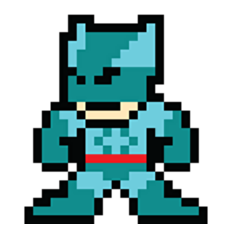

In [10]:
plt.imshow(img[:,:,::-1])
plt.axis('off')

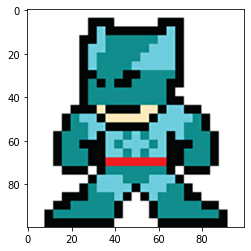

In [17]:
fig, (ax1) = plt.subplots(1)
ax1.imshow(img[:,:,::-1])

Display original image.

In [12]:
img_1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

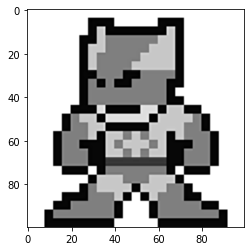

In [13]:
plt.imshow(img_1, cmap="gray")

Convert image to grayscale.

In [14]:
template = cv2.imread("shard.png")

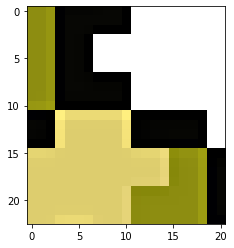

In [15]:
plt.imshow(template,)

Display template that we need to match.

In [35]:
template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)

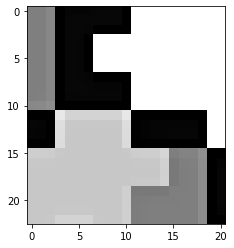

In [36]:
plt.imshow(template, cmap = "gray")

Convert it to grayscale.

In [50]:
template = rescale(template, 1.05, preserve_range=True, multichannel=False)

Import the Ciratefi algorithm.

In [45]:
import math
import warnings
from bisect import bisect_left

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import zoom


def cifi(template, search_image, thresh=90, use_percentile=True,
         radii=list(range(1,12)), scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], verbose=False):
    """
        Circular sampling filter (Cifi) uses projections of the template and search
        images on a set of circular rings to detect the first grade candidate pixels
        and the points' corresponding best fit scales for Ciratefi.
        A set of scales is applied to the template and is radially sampled for each radii
        'r' passed in. The template sample is equal to sum of the grayscale values
        divided by 2*pi*r.
        Each pixel in the search image is similarly sampled. Every pixel then gets
        correlated with the template samples at all scales. The scales with the highest
        correlation are the considered the 'best fit scales'.
        parameters
        ----------
        template : np.array
                   The input search template used to 'query' the destination
                   image
        search_image : np.array
                       The image or sub-image to be searched
        thresh : float
                 The correlation thresh hold above which a point will
                 be a first grade candidate point. If use_percentile=True
                 this will act as a percentile, for example, passing 90 means
                 keep values in the top 90th percentile
        use_percentile : bool
                         If True (default), thresh is a percentile instead of a hard
                         strength value
        radii : np.array
                The list of radii to use for radial sampling
        scales : list
                 The list of scales to be applied to the template image, best if
                 a geometric series
        verbose : bool
                  Set to True in order to output images and text describing the outputs. Can
                  cause a serious decrease in performance. False by default.
        returns
        -------
        fg_candidate_pixels : ndarray
                              array of pixels that passed the filter in tuples (y,x)
        best_scales : ndarray
                      parrallel array of best scales for the first grade candidate points
    """

    # check inputs for validity
    if template.shape > search_image.shape:
        raise ValueError('Template Image is smaller than Search Image for template of'
                         'size: {} and search image of size: {}'
                         .format(template.shape, search_image.shape))

    radii = np.asarray(radii)
    if not radii.size or not np.any(radii):
        raise ValueError('Input radii list is empty')

    scales = np.asarray(scales)
    if not scales.size or not np.any(scales):
        raise ValueError('Input scales list is empty')

    if max(radii) > max(template.shape)/2:
        warnings.warn('Max Radii is larger than original template, this may produce sub-par results.'
                      'Max radii: {} max template dimension: {}'.format(max(radii), max(template.shape)))

    if thresh < -1. or thresh > 1. and not use_percentile:
        raise ValueError('Thresholds must be in range [-1,1] when not using percentiles. Got: {}'
                         .format(thresh))

    # Cifi -- Circular Sample on Template
    template_result = np.empty((len(scales), len(radii)))

    for i, s in enumerate(scales):

        scaled_img = rescale(template, s, preserve_range=True, multichannel=False)
        for j, r in enumerate(radii):
            # Handle case where image shape is too small
            try:
                a, b = (int(scaled_img.shape[0] / 2),
                        int(scaled_img.shape[1] / 2))
            except:
                template_result[i, j] = -math.inf
                continue

            # if radius is bigger than extents, force sum to -1
            if r > b or r > a:
                template_result[i, j] = -math.inf
                continue

            # generate a circular mask
            mask = circ_mask(scaled_img.shape, (a, b), r)

            inv_area = 1 / (2 * math.pi * r)
            s = np.sum(scaled_img[mask]) * inv_area
            if s == 0:
                s = -1
            template_result[i, j] = s

    # Cifi2 -- Circular Sample on Target Image
    search_result = np.empty((search_image.shape[0], search_image.shape[1], len(radii)))

    for i, y in enumerate(range(search_image.shape[0])):
        for j, x in enumerate(range(search_image.shape[1])):
            for k, r in enumerate(radii):
                inv_area = 1 / (2 * math.pi * r)

                mask = circ_mask(search_image.shape, (i,j), r)
                s = np.sum(search_image[mask]) * inv_area

                if s == 0 or y < r or x < r or y+r > search_image.shape[0] or x+r > search_image.shape[1]:
                    s = -1
                search_result[i, j, k] = s

    # Perform Normalized Cross-Correlation between template and target image
    coeffs = np.empty((search_result.shape[0], search_result.shape[1]))
    best_scales = np.empty((search_result.shape[0], search_result.shape[1]))

    for y in range(search_result.shape[0]):
        for x in range(search_result.shape[1]):
            scale = 0
            max_coeff = -math.inf
            for i in range(template_result.shape[0]):

                result = cv2.matchTemplate(template_result[i].astype(np.float32),
                                           search_result[y, x].astype(np.float32), method=cv2.TM_CCORR_NORMED)
                score = np.average(result)

                if score > max_coeff:
                    max_coeff = score
                    scale = i

            coeffs[y, x] = max_coeff
            best_scales[y, x] = scales[scale]

    # get first grade candidate points

    if use_percentile:
        thresh = np.percentile(coeffs, thresh)

    fg_candidate_pixels = np.array([(y, x) for (y, x), coeff in np.ndenumerate(coeffs) if coeff >= thresh])

    if fg_candidate_pixels.size == 0:
        warnings.warn('Cifi returned empty set.')

    if verbose: # pragma: no cover
        plt.imshow(coeffs, interpolation='none')
        plt.show()

    return fg_candidate_pixels, best_scales


def rafi(template, search_image, candidate_pixels, best_scales, thresh=95,
         use_percentile=True, alpha=math.pi/8, radii=list(range(1, 12)), verbose=False):
    """
    The seconds filter in Ciratefi, the Radial Sampling Filter (Rafi), uses
    projections of the template image and the search image on a set of radial
    lines to upgrade the first grade the candidate pixels from cefi to
    seconds grade candidate pixels along with there corresponding best
    fit rotation.
    The template image is radially sampled at angles 0-2*pi at steps alpha and
    with the best fit radius (largest sampling radius from radii list that fits
    in the template image)
    Sampling for each line equals the sum of the greyscales divided by the
    best fit radius.
    The search image is similarly sampled at each candidate pixel and is correlated
    with the radial samples on the template. The best fit angle is the angle that
    maximizes this correlation, and the second grade candidate pixels are determined
    by the strength of the correlation and the passed threshold
    parameters
    ----------
    template : np.array
               The input search template used to 'query' the destination
               image
    search_image : np.array
                   The image or sub-image to be searched
    candidate_pixels : np.array
                       array of candidate pixels in tuples (y,x), best if
                       the pixel are the output of Cifi
    best_scales : ndarray
             The list of best fit scales for each candidate point,
             the length should equal the length of the candidate point
             list
    thresh : float
             The correlation thresh hold above which a point will
             be a first grade candidate point. If use_percentile=True
             this will act as a percentile, for example, passing 90 means
             keep values in the top 90th percentile
    use_percentile : bool
                     If True (default), thresh is a percentile instead of a hard
                     strength value
    alpha : float
            Must be greater than 0, if alpha is greater than 2*pi, it is reduced to it's
            equivalent angle in [0,2*pi]. alpha list = np.arange(0, 2*pi, alpha)
    radii : list
            The list of radii to use for radial sampling, best if the list
            is the same as the one used for Cifi
    verbose : bool
              Set to True in order to output images and text describing the outputs. Can
              cause a serious decrease in performance. False by default.
    returns
    -------
    sg_candidate_points : ndarray
    best_rotation : ndarray
                    Parrallel array of the best fit rotations for each
                    second grade candidate pixel
    """

    # check inputs for validity

    if search_image.shape < template.shape:
        raise ValueError('Template Image is smaller than Search Image for template of'
                         'size: {} and search image of size: {}'
                         .format(template.shape, search_image.shape))

    candidate_pixels = np.asarray(candidate_pixels)
    if not candidate_pixels.size or not np.any(candidate_pixels):
        raise ValueError('cadidate pixel list is empty')

    best_scales = np.asarray(best_scales, dtype=np.float32)
    if not best_scales.size or not np.any(best_scales):
        raise ValueError('best_scale list is empty')

    if best_scales.shape != search_image.shape:
        raise ValueError('Search image and scales must be of the same shape '
                         'got: best scales shape: {}, search image shape: {}'
                         .format(best_scales.shape, search_image.shape))

    radii = np.asarray(radii, dtype=int)
    if not radii.size or not np.any(radii):
        raise ValueError('Input radii list is empty')

    best_scales = np.asarray(best_scales, dtype=float)
    if not best_scales.size or not np.any(best_scales):
        raise ValueError('Input best_scales list is empty')

    if max(radii) > max(template.shape)/2:
        warnings.warn('Max Radii is larger than original template, this mat produce sub-par results.'
                      'Max radii: {} max template dimension: {}'.format(max(radii), max(template.shape)))

    if thresh < -1. or thresh > 1. and not use_percentile:
        raise ValueError('Thresholds must be in range [-1,1] when not using percentiles. Got: {}'
                         .format(thresh))

    if alpha <= 0:
        raise ValueError('Alpha must be >= 0')
    alpha %= 2*math.pi

    # Rafi 1  -- Get Radial Samples of Template Image
    alpha_list = np.arange(0, 2*math.pi, alpha)
    template_alpha_samples = np.zeros(len(alpha_list))
    center_y, center_x = (int(template.shape[0] / 2),
                          int(template.shape[1] / 2))

    # find the largest fitting radius
    rad_thresh = max(center_x, center_y)

    if rad_thresh >= max(radii):
        radius = max(radii)
    else:
        radius = radii[bisect_left(radii, rad_thresh)]

    for i in range(len(template_alpha_samples)):
        # Create Radial Line Mask
        mask = radial_line_mask(template.shape, (center_y, center_x), radius, alpha=alpha_list[i])

        # Sum the values
        template_alpha_samples[i] = np.sum(template[mask])/radius

    # Rafi 2 -- Get Radial Samples of the Search Image for all First Grade Candidate Points
    rafi_alpha_means = np.zeros((len(candidate_pixels), len(alpha_list)))

    for i in range(len(candidate_pixels)):
        y, x = candidate_pixels[i]

        rad = radius if min(y, x) > radius else min(y, x)
        cropped_search = search_image[y-rad:y+rad+1, x-rad:x+rad+1]
        scaled_img = rescale(cropped_search, best_scales[y, x], preserve_range=True, multichannel=False)

        # Will except if image size too small after scaling
        try:
            scaled_center_y, scaled_center_x = (math.floor(scaled_img.shape[0]/2),
                                                math.floor(scaled_img.shape[1]/2))
        except:
            warnings.warn('{}\' window is to small to use for scale {} at resulting size'
                          .format((y, x), best_scales[y, x], scaled_img.shape))
            rafi_alpha_means[i] = np.negative(np.ones(len(alpha_list)))
            continue

        for j in range(len(alpha_list)):
            # Create Radial Mask
            mask = radial_line_mask(scaled_img.shape, (scaled_center_y, scaled_center_x),
                                         scaled_center_y, alpha=alpha_list[j])
            rafi_alpha_means[i, j] = np.sum(scaled_img[mask])/radius

    best_rotation = np.zeros(len(candidate_pixels))
    rafi_coeffs = np.zeros(len(candidate_pixels))

    if verbose: # pragma: no cover
        image_pixels = np.zeros((search_image.shape[0], search_image.shape[1]))

    # Perform Normalized Cross-Correlation between template and target image
    for i in range(len(candidate_pixels)):
        maxcoeff = -math.inf
        maxrotate = 0
        y, x = candidate_pixels[i]
        for j in range(len(alpha_list)):
            # perform circular shifting of template sums
            shifted_template_angle_sums = np.roll(template_alpha_samples, j)
            result = cv2.matchTemplate(shifted_template_angle_sums.astype(np.float32),
                                       rafi_alpha_means[i].astype(np.float32), method=cv2.TM_CCORR_NORMED)
            score = np.average(result)

            if score > maxcoeff:
                maxcoeff = score
                maxrotate = j

        rafi_coeffs[i] = maxcoeff
        best_rotation[i] = alpha_list[maxrotate]
        if verbose: # pragma: no cover
            image_pixels[y, x] = maxcoeff

    # Get second grade candidate points and best rotation

    if use_percentile:
        thresh = np.percentile(rafi_coeffs, thresh)

    rafi_mask = rafi_coeffs >= thresh
    sg_candidate_points = candidate_pixels[rafi_mask]
    best_rotation = best_rotation[rafi_mask]

    if sg_candidate_points.size == 0:
        warnings.warn('Second filter Rafi returned empty set.')

    if verbose: # pragma: no cover
        plt.imshow(image_pixels, interpolation='none')
        plt.show()

    return sg_candidate_points, best_rotation


def tefi(template, search_image, candidate_pixels, best_scales, best_angles,
         scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], upsampling=1, thresh=100,
         alpha=math.pi/16, use_percentile=True, verbose=False):
    """
    Template Matching Filter (Tefi) is the third and final filter for ciratefi.
    For every candidate pixel, tefi rotates and scales the template image by the list
    of scales and angles passed in (which, ideally are the output from cefi and rafi
    respectively) and performs template match around the candidate pixels at the
    approriate scale and rotation angle. Here, the scales, angles and candidate
    points should be a parrallel array structure.
    Any points with correlation strength over the threshold are returned as
    the the strongest candidates for the image location. If knows the point
    exists in one location, thresh should be 100 and use_percentile = True.
    parameters
    ----------
    template : ndarray
               The input search template used to 'query' the destination
               image
    image : ndarray
            The image or sub-image to be searched
    candidate_pixels : ndarray
                       array of candidate pixels in tuples (y,x), best if
                       the pixel are the output of Cifi
    best_scales : ndarray
                  The list of best fit scales for each candidate point, the length
                  should equal the length of the candidate point list
    best_angles : ndarray
                  The list of best fit rotation for each candidate point in radians,
                  the length should equal the length of the candidate point list
    upsampling : int
                 upsample degree
    thresh : float
             The correlation thresh hold above which a point will
             be a first grade candidate point. If use_percentile=True
             this will act as a percentile, for example, passing 90 means
             keep values in the top 90th percentile
    use_percentile : bool
                     If True (default), thresh is a percentile instead of a hard
                     strength value
    alpha : float
            A float between 0 & 2*pi, alpha list = np.arange(0, 2*pi, alpha)
    verbose : bool
              Set to True in order to output images and text describing the outputs. Can
              cause a serious decrease in performance. False by default.
    returns
    -------
    results : ndarray
              array of pixel tuples (y,x) which over the threshold
    """

    # check all inputs for validity, probably a better way to do this

    if search_image.shape < template.shape:
        raise ValueError('Template Image is smaller than Search Image for template of'
                         'size: {} and search image of size: {}'
                         .format(template.shape, search_image.shape))

    candidate_pixels = np.asarray(candidate_pixels)
    if not candidate_pixels.size or not np.any(candidate_pixels):
        raise ValueError('cadidate pixel list is empty')

    best_scales = np.asarray(best_scales, dtype=np.float32)
    if not best_scales.size or not np.any(best_scales):
        raise ValueError('best_scale list is empty')

    if best_scales.shape != search_image.shape:
        raise ValueError('Search image and scales must be of the same shape '
                         'got: best scales shape: {}, search image shape: {}'
                         .format(best_scales.shape, search_image.shape))

    best_angles = np.asarray(best_angles, dtype=np.float32)
    if not best_angles.size or not np.any(best_angles):
        raise ValueError('Input best angle list is empty')

    best_scales = np.asarray(best_scales, dtype=float)
    if not best_scales.size or not np.any(best_scales):
        raise ValueError('Input best_scales list is empty')

    if thresh < -1. or thresh > 1. and not use_percentile:
        raise ValueError('Thresholds must be in range [-1,1] when not using percentiles. Got: {}'
                         .format(thresh))

    # Check inputs
    if upsampling < 1:
        raise ValueError('Upsampling must be >= 1, got {}'.format(upsampling))

    tefi_coeffs = np.zeros(candidate_pixels.shape[0])

    # if verbose, preallocate pixel data
    if verbose: # pragma: no cover
        image_pixels = np.zeros((search_image.shape[0], search_image.shape[1]))

    # check for upsampling
    if upsampling > 1:
        u_template = zoom(template, upsampling, order=3)
        u_search_image = zoom(search_image, upsampling, order=3)

    alpha_list = np.arange(0, 2*math.pi, alpha)
    candidate_pixels *= int(upsampling)

    # Tefi -- Template Matching Filter
    for i in range(len(candidate_pixels)):
        y, x = candidate_pixels[i]

        try:
            best_scale_idx = (np.where(scales == best_scales[y//upsampling, x//upsampling]))[0][0]
            best_alpha_idx = (np.where(np.isclose(alpha_list, best_angles[i], atol=.01)))[0][0]
        except:
            tefi_coeffs[i] = 0
            continue

        tefi_scales = np.array(scales).take(range(best_scale_idx-1, best_scale_idx+2), mode='wrap')
        tefi_alphas = alpha_list.take(range(best_alpha_idx-1, best_alpha_idx+2), mode='wrap')

        scalesxalphas = cartesian([tefi_scales, tefi_alphas])

        max_coeff = -math.inf
        for j in range(scalesxalphas.shape[0]):
            transformed_template = rescale(u_template, scalesxalphas[j][0],preserve_range=True, multichannel=False)
            transformed_template = rotate(transformed_template, scalesxalphas[j][1])

            y_window, x_window = (math.floor(transformed_template.shape[0]/2),
                                  math.floor(transformed_template.shape[1]/2))

            cropped_search = u_search_image[y-y_window:y+y_window+1, x-x_window:x+x_window+1]

            if(y < y_window or x < x_window or cropped_search.shape < transformed_template.shape or
               cropped_search.shape != transformed_template.shape):
                score = -1
            else:
                result = cv2.matchTemplate(transformed_template.astype(np.float32), cropped_search.astype(np.float32), method=cv2.TM_CCORR_NORMED)
                score = np.average(result)

            if score > max_coeff:
                max_coeff = score

        tefi_coeffs[i] = max_coeff

        if verbose: # pragma: no cover
            image_pixels[y//upsampling, x//upsampling] = max_coeff

    if use_percentile:
        thresh = np.percentile(tefi_coeffs, int(thresh))

    result_points = candidate_pixels[np.where(tefi_coeffs >= thresh)]
    result_coeffs = tefi_coeffs[np.where(tefi_coeffs >= thresh)]

    x = result_points[0][1]
    y = result_points[0][0]

    ideal_y = u_search_image.shape[0] / 2
    ideal_x = u_search_image.shape[1] / 2

    if verbose:  # pragma: no cover
        plt.imshow(image_pixels, interpolation='none')
        plt.scatter(y=y/upsampling, x=x/upsampling, c='w', s=80)
        plt.show()
        
        plt.imshow(img_1, interpolation='none')
        plt.scatter(y=y/upsampling, x=x/upsampling, c='w', s=80)
        plt.show()

    x = (ideal_x - x)/upsampling
    y = (ideal_y - y)/upsampling

    return x, y, result_coeffs[0]


def ciratefi(template, search_image, upsampling=1, cifi_thresh=95, rafi_thresh=95, tefi_thresh=100,
             use_percentile=True, alpha=math.pi/16, scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0],
             radii=list(range(1, 12)), verbose=False):
    """
    Parameters
    ----------
    template : ndarray
               The input search template used to 'query' the destination
               image
    search_image : ndarray
                   The image or sub-image to be searched
    upsampling : int
                 upsample degree
    cifi_thresh : float
             The correlation thresh hold for cifi above which a point will
             be a first grade candidate point. If use_percentile=True
             this will act as a percentile, for example, passing 90 means
             keep values in the top 90th percentile
    rafi_thresh : float
                  The correlation thresh hold for rafi above which a point will
                  be a first grade candidate point. If use_percentile=True
                  this will act as a percentile, for example, passing 90 means
                  keep values in the top 90th percentile
    tefi_thresh : float
                  The correlation thresh hold for tefi above which a point will
                  be a first grade candidate point. If use_percentile=True
                  this will act as a percentile, for example, passing 90 means
                  keep values in the top 90th percentile
    use_percentile : bool
                     If True (default), thresh is a percentile instead of a hard
                     strength value
    alpha : float
            Must be greater than 0, if alpha is greater than 2*pi, it is reduced to it's
            equivalent angle in [0,2*pi]. alpha list = np.arange(0, 2*pi, alpha)
    radii : np.array
            The list of radii to use for radial sampling
    scales : list
             The list of scales to be applied to the template image, best if
             a geometric series
    verbose : bool
              Set to True in order to output images and text describing the outputs. Can
              cause a serious decrease in performance. False by default.
    Returns
    -------
    results : ndarray
              array of pixel in (y, x)
    """

    # Perform first filter cifi
    fg_candidate_pixels, best_scales = cifi(template, search_image, thresh=cifi_thresh,
                                            use_percentile=use_percentile,
                                            scales=scales, radii=radii, verbose=verbose)
    # Perform second filter rafi
    sg_candidate_points, best_rotation = rafi(template, search_image, fg_candidate_pixels, best_scales,
                                              thresh=rafi_thresh, use_percentile=use_percentile, alpha=alpha,
                                              radii=radii, verbose=verbose)

    # Perform last filter tefi
    results = tefi(template, search_image, sg_candidate_points, best_scales, best_rotation,
                   thresh=tefi_thresh, alpha=math.pi/4, use_percentile=True, upsampling=upsampling, verbose=verbose)

    # return the points found
    return results


def to_polar_coord(shape, center):
    """
    Generate a polar coordinate grid from a shape given
    a center.
    parameters
    ----------
    shape : tuple
            tuple decribing the desired shape in
            (y,x)
    center : tuple
             tuple describing the desired center
             for the grid
    returns
    -------
    r2 : ndarray
         grid of radii from the center
    theta : ndarray
            grid of angles from the center
    """

    y, x = np.ogrid[:shape[0], :shape[1]]
    cy, cx = center
    tmin, tmax = (0, 2*math.pi)

    # ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx, y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    return r2, theta


def circ_mask(shape, center, radius):
    """
    Generates a circular mask
    parameters
    ----------
    shape : tuple
            tuple decribing the desired mask shape in
            (y,x)
    center : tuple
             tuple describing the desired center
             for the circle
    radius : float
             radius of circlular mask
    returns
    -------
    mask : ndarray
           circular mask of bools
    """

    r, theta = to_polar_coord(shape, center)

    circle_mask = r == radius*radius
    angle_mask = theta <= 2*math.pi

    return circle_mask*angle_mask


def radial_line_mask(shape, center, radius, alpha=0.19460421, atol=.01):
    """
    Generates a linear mask from center at angle alpha.
    parameters
    ----------
    shape : tuple
            tuple decribing the desired mask shape in
            (y,x)
    center : tuple
             tuple describing the desired center
             for the circle
    radius : float
             radius of the line mask
    alpha : float
            angle for the line mask
    atol : float
           absolute tolerance for alpha, the higher
           the tolerance, the wider the angle bandwidth
    returns
    -------
    mask : ndarray
           linear mask of bools
    """

    r, theta = to_polar_coord(shape, center)

    line_mask = r <= radius**2
    anglemask = np.isclose(theta, [alpha], atol=atol)

    return line_mask*anglemask

def cartesian(arrays, out=None):

    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    from scikit-learn
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py
    """
    arrays = [np.asarray(x) for x in arrays]
    shape = (len(x) for x in arrays)
    dtype = arrays[0].dtype

    ix = np.indices(shape)
    ix = ix.reshape(len(arrays), -1).T

    if out is None:
        out = np.empty_like(ix, dtype=dtype)

    for n, arr in enumerate(arrays):
        out[:, n] = arrays[n][ix[:, n]]

    return out

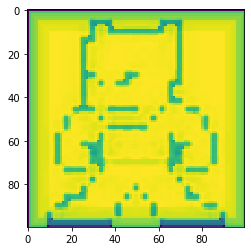

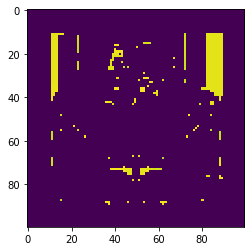

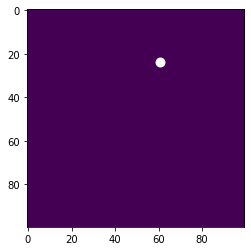

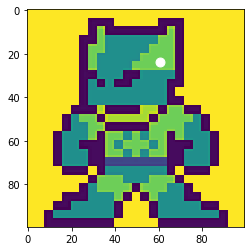

(-10.909090909090908, 26.36363636363636, 0.0)

In [51]:
ciratefi(template, img_1, upsampling = 1.1, verbose = True)

The result is shown in the last picture, with a white dot, which indicate the template area. As we can see, the result is quite satisfactory.

In [20]:
template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)

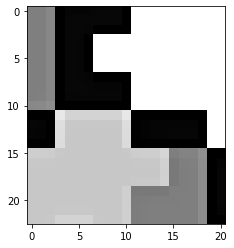

In [21]:
plt.imshow(template, cmap = "gray")